<a href="https://colab.research.google.com/github/marufiqbal5g/ANPR-System/blob/main/detect_and_recognize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x8

In [ ]:
from ultralytics import YOLO
from easyocr import Reader

In [ ]:
import time
import torch
import cv2
import os
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CONFIDENCE_THRESHOLD = 0.4
COLOR = (0, 255, 0)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def detect_number_plates(image, model, display=False):
    start = time.time()
    # pass the image through the model and get the detections
    detections = model.predict(image)[0].boxes.data

    # check to see if the detections tensor is not empty
    if detections.shape != torch.Size([0, 6]):

        # initialize the list of bounding boxes and confidences
        boxes = []
        confidences = []

        # loop over the detections
        for detection in detections:
            # extract the confidence (i.e., probability) associated
            # with the prediction
            confidence = detection[4]

            # filter out weak detections by ensuring the confidence
            # is greater than the minimum confidence
            if float(confidence) < CONFIDENCE_THRESHOLD:
                continue

            # if the confidence is greater than the minimum confidence, add
            # the bounding box and the confidence to their respective lists
            boxes.append(detection[:4])
            confidences.append(detection[4])

        print(f"{len(boxes)} Number plate(s) have been detected.")
        # initialize a list to store the bounding boxes of the
        # number plates and later the text detected from them
        number_plate_list= []

        # loop over the bounding boxes
        for i in range(len(boxes)):
            # extract the bounding box coordinates
            xmin, ymin, xmax, ymax = int(boxes[i][0]), int(boxes[i][1]),\
                                     int(boxes[i][2]), int(boxes[i][3])
            # append the bounding box of the number plate
            number_plate_list.append([[xmin, ymin, xmax, ymax]])

            # draw the bounding box and the label on the image
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), COLOR, 2)
            text = "Number Plate: {:.2f}%".format(confidences[i] * 100)
            cv2.putText(image, text, (xmin, ymin - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLOR, 2)

            if display:
                # crop the detected number plate region
                number_plate = image[ymin:ymax, xmin:xmax]
                # display the number plate
                cv2_imshow(number_plate)
                # cv2_imshow(f"Number plate {i}", number_plate)

        end = time.time()
        # show the time it took to detect the number plates
        print(f"Time to detect the number plates: {(end - start) * 1000:.0f} milliseconds")
        # return the list containing the bounding
        # boxes of the number plates
        return number_plate_list
    # if there are no detections, show a custom message
    else:
        print("No number plates have been detected.")
        return []

In [ ]:
def recognize_number_plates(image_or_path, reader,
                            number_plate_list, write_to_csv=False):

    start = time.time()
    # if the image is a path, load the image; otherwise, use the image
    image = cv2.imread(image_or_path) if isinstance(image_or_path, str)\
                                      else image_or_path

    for i, box in enumerate(number_plate_list):
        # crop the number plate region
        np_image = image[box[0][1]:box[0][3], box[0][0]:box[0][2]]

        # detect the text from the license plate using the EasyOCR reader
        detection = reader.readtext(np_image, paragraph=True)

        if len(detection) == 0:
            # if no text is detected, set the `text` variable to an empty string
            text = ""
        else:
            # set the `text` variable to the detected text
            text = str(detection[0][1])

        # update the `number_plate_list` list, adding the detected text
        number_plate_list[i].append(text)

    if write_to_csv:
        # open the CSV file
        csv_file = open("number_plates.csv", "w")
        # create a writer object
        csv_writer = csv.writer(csv_file)
        # write the header
        csv_writer.writerow(["image_path", "box", "text"])

        # loop over the `number_plate_list` list
        for box, text in number_plate_list:
            # write the image path, bounding box coordinates,
            # and detected text to the CSV file
            csv_writer.writerow([image_or_path, box, text])
        # close the CSV file
        csv_file.close()

    end = time.time()
    # show the time it took to recognize the number plates
    print(f"Time to recognize the number plates: {(end - start) * 1000:.0f} milliseconds")

    return number_plate_list

In [ ]:
os.getcwd()

In [ ]:
os.chdir('/content/drive/MyDrive/Transport AI/DEMO_PROJECT/datasets/')

Processing the video...

0: 384x640 9 number plates, 643.9ms
Speed: 4.0ms preprocess, 643.9ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
8 Number plate(s) have been detected.
Time to detect the number plates: 2255 milliseconds
Time to recognize the number plates: 820 milliseconds


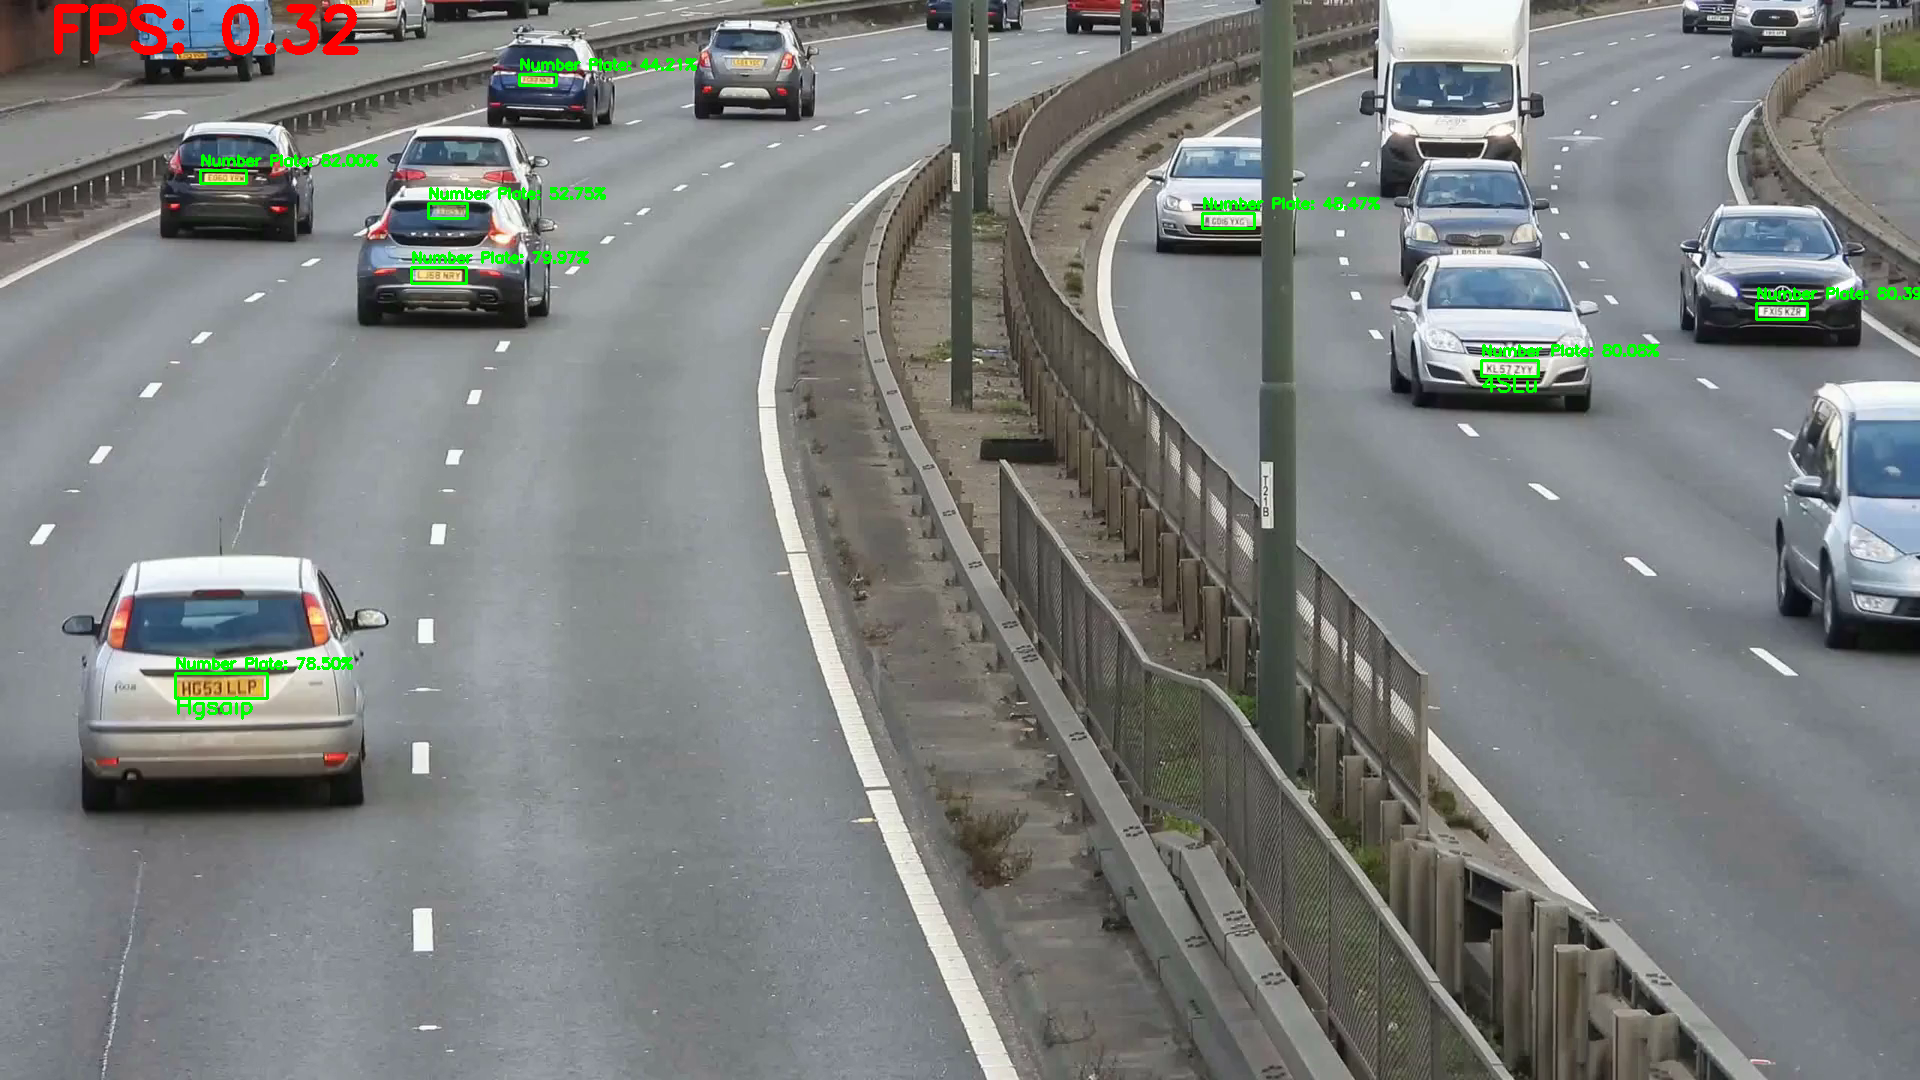


0: 384x640 9 number plates, 641.3ms
Speed: 6.9ms preprocess, 641.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
8 Number plate(s) have been detected.
Time to detect the number plates: 671 milliseconds
Time to recognize the number plates: 865 milliseconds


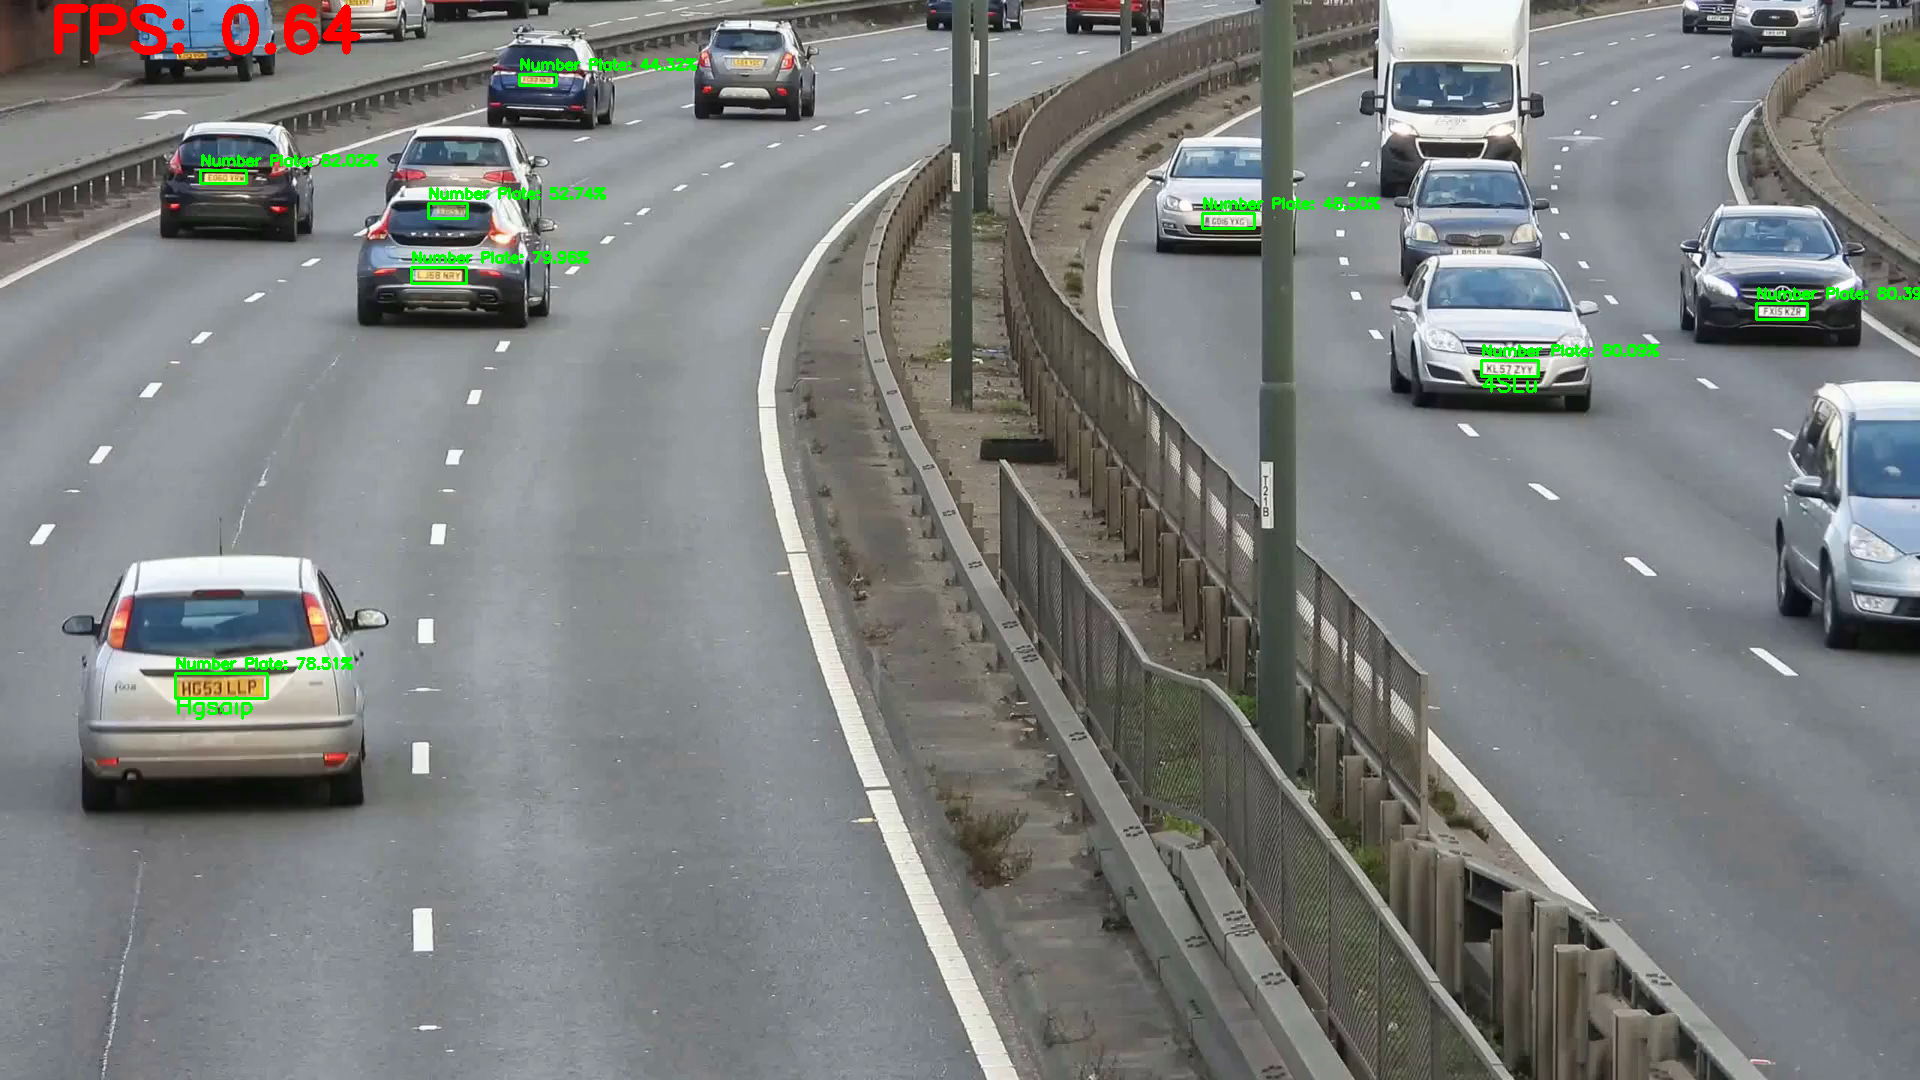


0: 384x640 8 number plates, 537.7ms
Speed: 4.0ms preprocess, 537.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
8 Number plate(s) have been detected.
Time to detect the number plates: 562 milliseconds
Time to recognize the number plates: 555 milliseconds


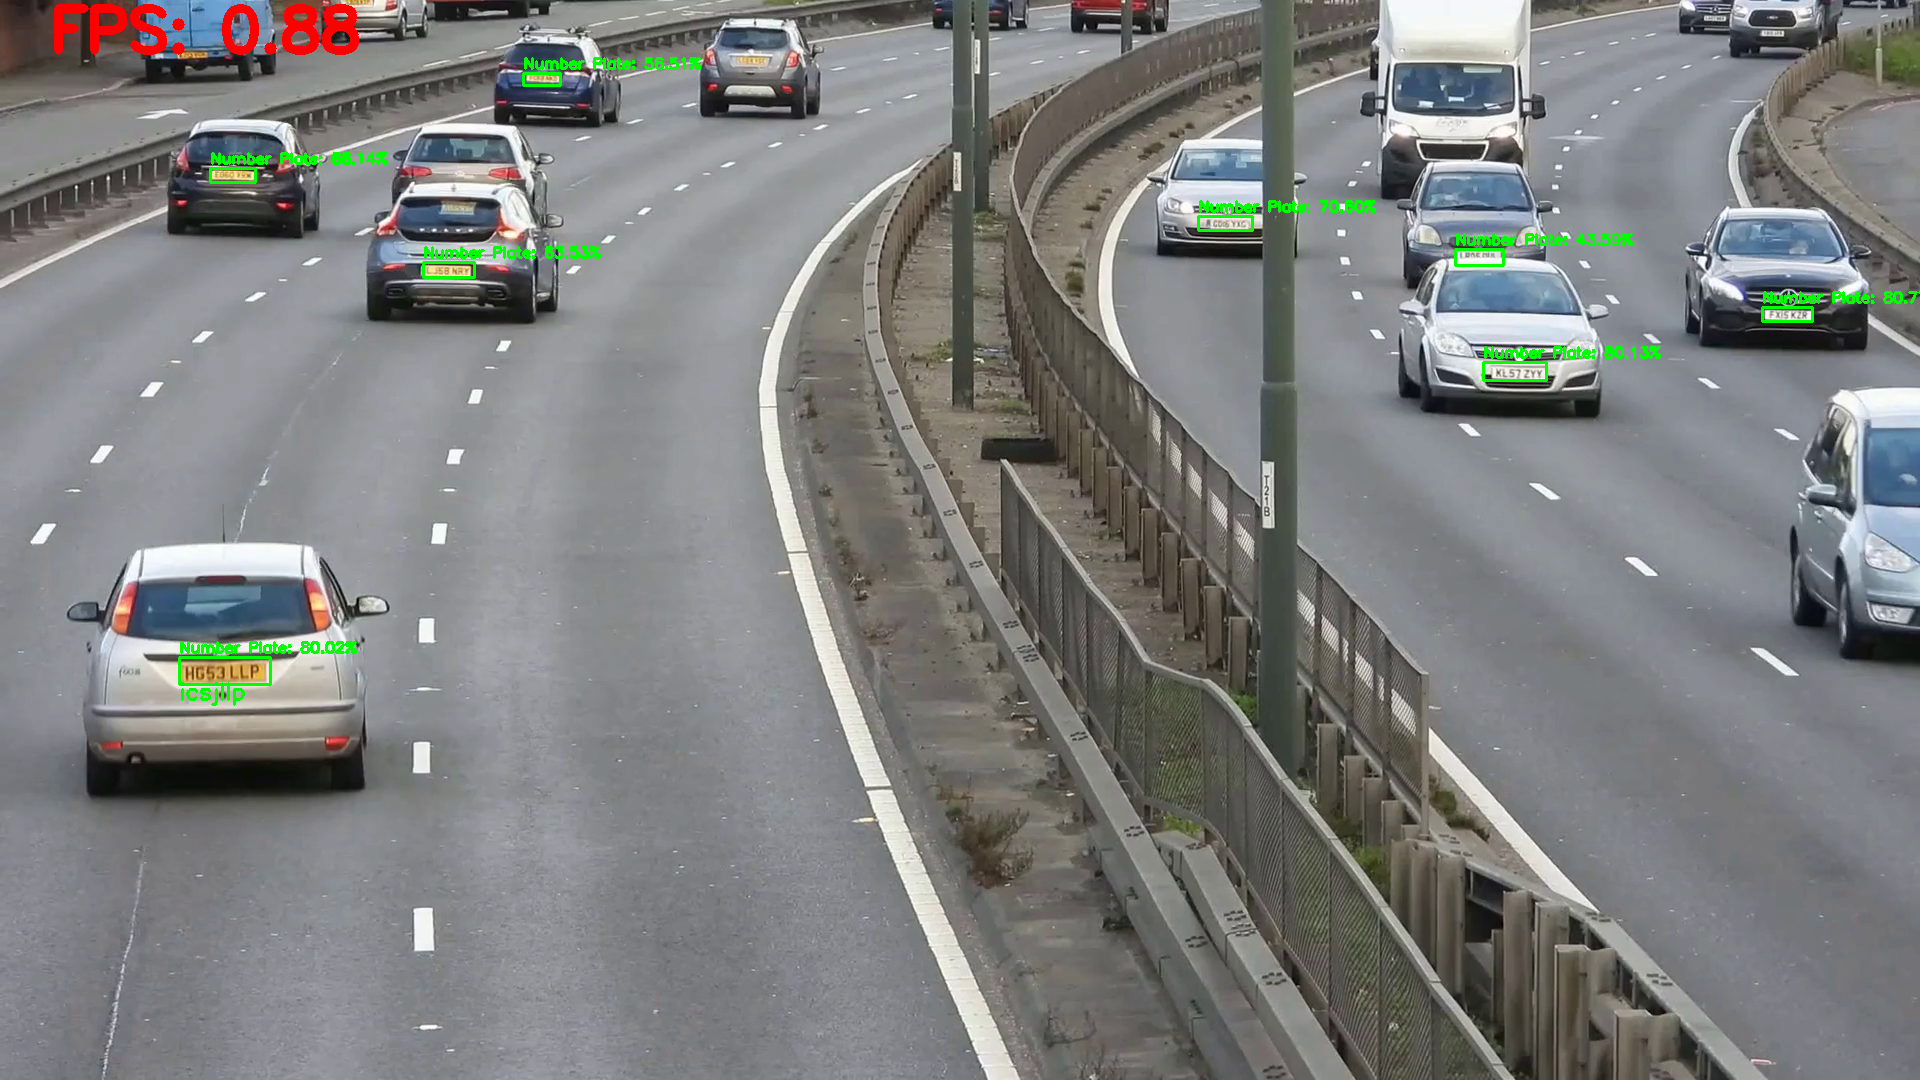


0: 384x640 8 number plates, 562.2ms
Speed: 4.0ms preprocess, 562.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
8 Number plate(s) have been detected.
Time to detect the number plates: 577 milliseconds
Time to recognize the number plates: 525 milliseconds


In [ ]:
# if this script is executed directly, run the following code
if __name__ == "__main__":

    # load the model from the local directory
    model = YOLO("/content/drive/MyDrive/Transport AI/DEMO_PROJECT/runs/detect/train_new/weights/best.pt")
    # initialize the EasyOCR reader
    reader = Reader(['en'], gpu=True)

    # path to an image or a video file
    # file_path = "/content/drive/MyDrive/Transport AI/DEMO_PROJECT/datasets/images/test/download/downloaded_image.jpg"
    file_path = "/content/drive/MyDrive/Transport AI/DEMO_PROJECT/datasets/car-number-plate/videos/Traffic_5s.mp4"
    # Extract the file name and the file extension from the file path
    _, file_extension = os.path.splitext(file_path)

    # Check the file extension
    if file_extension in ['.jpg', '.jpeg', '.png']:
        print("Processing the image...")

        image = cv2.imread(file_path)
        number_plate_list = detect_number_plates(image, model, display=True)
        cv2_imshow(image)
        # cv2.imshow('Image', image)
        cv2.waitKey(0)

        # if there are any number plates detected, recognize them
        if number_plate_list != []:
            number_plate_list = recognize_number_plates(file_path, reader,
                                                        number_plate_list,
                                                        write_to_csv=True)

            for box, text in number_plate_list:
                cv2.putText(image, text, (box[0], box[3] + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLOR, 2)
            cv2_imshow(image)
            cv2.waitKey(0)

    elif file_extension in ['.mp4', '.mkv', '.avi', '.wmv', '.mov']:
        print("Processing the video...")

        video_cap = cv2.VideoCapture(file_path)

        # grab the width and the height of the video stream
        frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(video_cap.get(cv2.CAP_PROP_FPS))
        # initialize the FourCC and a video writer object
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter("output.mp4", fourcc, fps,
                                 (frame_width, frame_height))

        # loop over the frames
        while True:
            # starter time to computer the fps
            start = time.time()
            success, frame = video_cap.read()

            # if there is no more frame to show, break the loop
            if not success:
                print("There are no more frames to process."
                      " Exiting the script...")
                break

            number_plate_list = detect_number_plates(frame, model)

            if number_plate_list != []:
                number_plate_list = recognize_number_plates(frame, reader,
                                                        number_plate_list)

                for box, text in number_plate_list:
                    cv2.putText(frame, text, (box[0], box[3] + 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.75, COLOR, 2)

            # end time to compute the fps
            end = time.time()
            # calculate the frame per second and draw it on the frame
            fps = f"FPS: {1 / (end - start):.2f}"
            cv2.putText(frame, fps, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)

            # show the output frame
            cv2_imshow(frame)
            # write the frame to disk
            writer.write(frame)
            # if the 'q' key is pressed, break the loop
            if cv2.waitKey(10) == ord("q"):
                break

        # release the video capture, video writer, and close all windows
        video_cap.release()
        writer.release()
        cv2.destroyAllWindows()

Processing the image...

0: 416x640 1 number plate, 843.0ms
Speed: 26.8ms preprocess, 843.0ms inference, 21.5ms postprocess per image at shape (1, 3, 416, 640)
1 Number plate(s) have been detected.


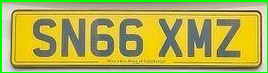

Time to detect the number plates: 2964 milliseconds


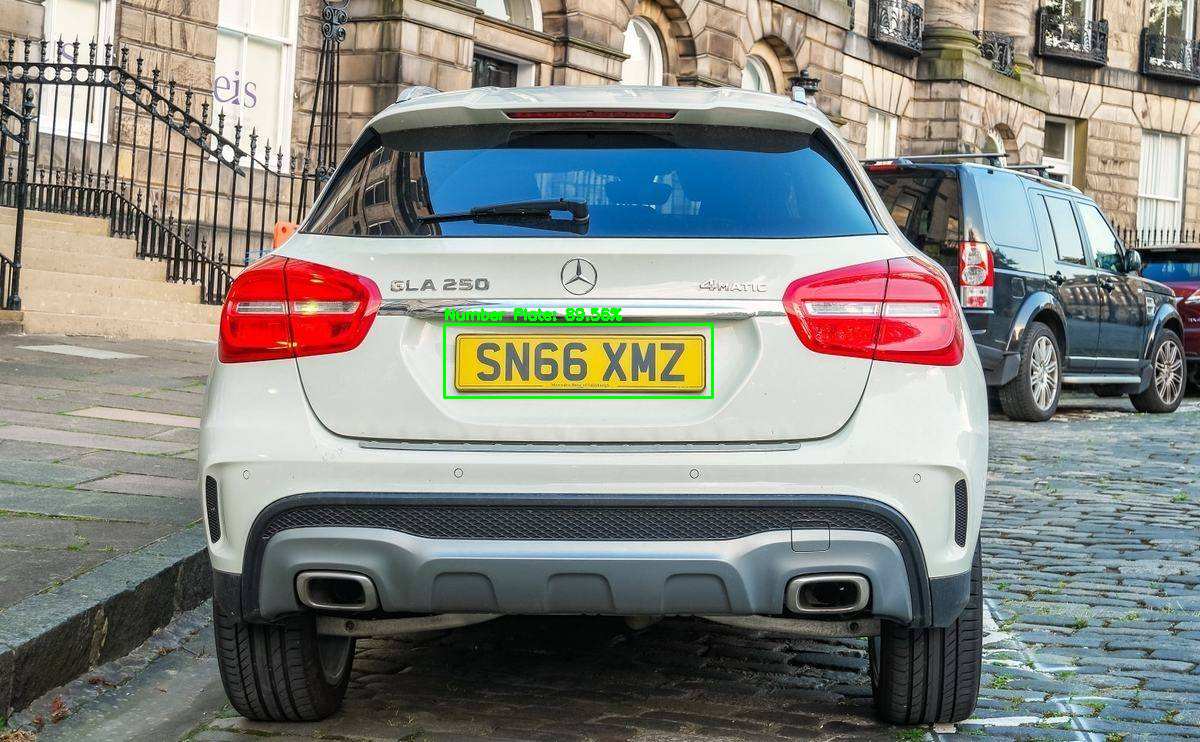

In [ ]:
# if this script is executed directly, run the following code
if __name__ == "__main__":

    # load the model from the local directory
    model = YOLO("/content/drive/MyDrive/Transport AI/DEMO_PROJECT/runs/detect/train_new/weights/best.pt")

    file_path = "/content/drive/MyDrive/Transport AI/DEMO_PROJECT/datasets/images/test/download/downloaded_image.jpg"
    # file_path = "/content/drive/MyDrive/Transport AI/DEMO_PROJECT/datasets/car-number-plate/videos/Traffic_5s.mp4"

    _, file_extension = os.path.splitext(file_path)

    if file_extension in ['.jpg', '.jpeg', '.png']:
        print("Processing the image...")

        image = cv2.imread(file_path)
        number_plate_list = detect_number_plates(image, model, display=True)
        cv2_imshow (image)
        # # cv2.imshow('Image', image)
        cv2.waitKey(0)

    elif file_extension in ['.mp4', '.mkv', '.avi', '.wmv', '.mov']:
        print("Processing the video...")

        video_cap = cv2.VideoCapture(file_path)

        # grab the width and the height of the video stream
        frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(video_cap.get(cv2.CAP_PROP_FPS))
        # initialize the FourCC and a video writer object
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter("output.mp4", fourcc, fps,
                                 (frame_width, frame_height))

        # loop over the frames
        while True:
            # starter time to computer the fps
            start = time.time()
            success, frame = video_cap.read()

            # if there is no more frame to show, break the loop
            if not success:
                print("There are no more frames to process."
                      " Exiting the script...")
                break

            number_plate_list = detect_number_plates(frame, model)

            # if number_plate_list != []:
            #     number_plate_list = recognize_number_plates(frame, reader,
            #                                             number_plate_list)

            #     for box, text in number_plate_list:
            #         cv2.putText(frame, text, (box[0], box[3] + 15),
            #                     cv2.FONT_HERSHEY_SIMPLEX, 0.75, COLOR, 2)

            # end time to compute the fps
            end = time.time()
            # calculate the frame per second and draw it on the frame
            fps = f"FPS: {1 / (end - start):.2f}"
            cv2.putText(frame, fps, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)

            # show the output frame
            cv2_imshow(frame)
            # write the frame to disk
            writer.write(frame)
            # if the 'q' key is pressed, break the loop
            if cv2.waitKey(10) == ord("q"):
                break

        # release the video capture, video writer, and close all windows
        video_cap.release()
        writer.release()
        cv2.destroyAllWindows()